# Benchmark 1: 2D Geometric Shapes

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from enum import Enum, auto

import torch
import torch.nn as nn
import torch.nn.functional as F


class NoiseType(Enum):
    DIAGONAL = auto()
    ISOTROPIC = auto()
    ISOTROPIC_ACROSS_CLUSTERS = auto()
    FIXED = auto()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Define a decorator that randomly selects one of the multi-valued outputs
def rand_mod(y_func):
    def wrapper(x, *args, **kwargs):
        y_values = y_func(x, *args, **kwargs)
        y_rand = np.random.choice(y_values)
        return y_rand + 0.02 * np.random.randn(*y_rand.shape)
    return wrapper

Device: cpu


In [2]:
# Multi-valude function of x -> y1, y2, y3 ...
def y_circle(x, r = 1):
    y1 = np.sqrt(r - x**2)
    y2 = -np.sqrt(r - x**2)
    return y1, y2

def y_line(x, m = 1):
    return m * x, 0, -m * x

def y_hyperbola(x, a = 0.1, b = 1):
    y1 = np.sqrt(a**2 + b**2 * x**2)
    y2 = -np.sqrt(a**2 + b**2 * x**2)
    return y1, y2

def y_parabola(x, a = 1):
    return a * x**2, -a * x**2


## Selecting the Shape

Please select the 2D shape for the analysis.

In [3]:
y_multi = y_hyperbola

True


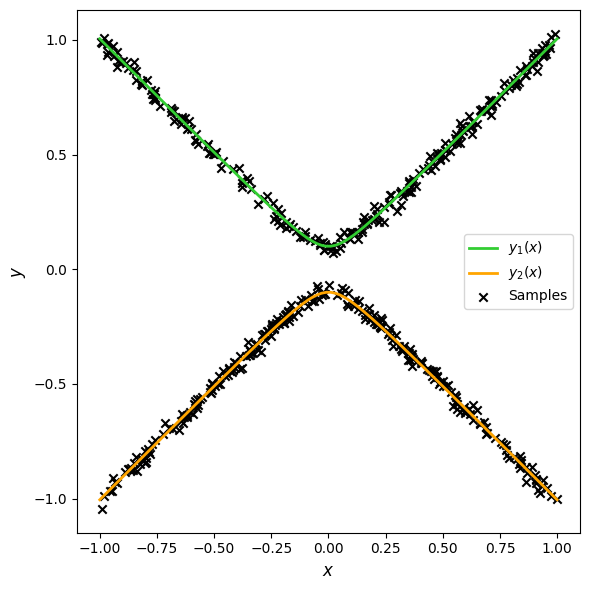

In [4]:
# Apply the rand_mod function to y_circle
y_multi_rand = rand_mod(y_multi)

# Create a dataset of (x, y) pairs
num_samples = 500
x = np.random.uniform(-1, 1, num_samples)
y = np.array([y_multi_rand(x_i) for x_i in x])

# # If we want not conflicting data
# num_samples = 500
# x = np.random.uniform(-1, 1, num_samples)
# y = np.array([y_multi(x_i)[0] for x_i in x])

print(x.shape == y.shape)

# Load dataset
batch_size = 32
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot the function and the samples
x_vals = np.linspace(-1, 1, 100)
y_vals = [y_multi(x_i) for x_i in x_vals]
y_vals_transposed = list(zip(*y_vals))

# Data bounds for counter-sample generation
y_min = torch.tensor([-1])  # Joint y_target limits (radians)
y_max = torch.tensor([1])

# Plot the function and the samples
plt.figure(figsize=(6, 6))
colors = ['limegreen', 'orange']  # Colors for the two modes

for i, (y_val, color) in enumerate(zip(y_vals_transposed, colors)):
    plt.plot(x_vals, y_val, color=color, label=f'$y_{i+1}(x)$', linewidth=2)

plt.scatter(x, y, marker='x', color='black', label='Samples')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig('2d_geometric_shapes.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Evaluation metrics

In [7]:
from scipy.stats import entropy, wasserstein_distance

def compute_metrics(real_samples, generated_samples, num_bins=50):
    """Compute the number of modes covered, KL divergence, and Wasserstein distance."""
    # Bin the samples
    hist_real, bins = np.histogram(real_samples, bins=num_bins, density=True)
    hist_generated, _ = np.histogram(generated_samples, bins=bins, density=True)

    # Smooth histograms to avoid zero probabilities
    hist_real += 1e-8
    hist_generated += 1e-8

    # Normalize histograms
    hist_real /= hist_real.sum()
    hist_generated /= hist_generated.sum()

    # KL Divergence
    kl_div = entropy(hist_real, hist_generated)

    # Wasserstein Distance
    w_distance = wasserstein_distance(hist_real, hist_generated)

    # Modes Covered
    real_modes = (hist_real > 0.01).sum()
    generated_modes = (hist_generated > 0.01).sum()
    modes_covered = min(real_modes, generated_modes)

    return kl_div, w_distance, modes_covered

# Problem set-up Parameter


In [8]:
input_size = 1  # x, y x_input
action_size = 1  # joint y_target
condition_size = 1
output_size = 1

# EBGAN-MDN

In [9]:
def evaluate_model(energy_model, generator, epoch, latent_size, device):
    # Generate grid points within the range of x values
    x_range = np.linspace(-1, 1, 100)
    y_range = np.linspace(-1, 1, 100)
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    grid_points = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).to(device)

    # Compute energy model output for each grid point
    energy_outputs = energy_model(grid_points[:, :1], grid_points[:, 1:]).detach().cpu().numpy()
    energy_outputs = energy_outputs.reshape(100, 100)

    # Normalize every column of the heatmap
    energy_outputs = (energy_outputs - energy_outputs.min(axis=0)) / (energy_outputs.max(axis=0) - energy_outputs.min(axis=0))

    # Plot the heatmap and the function, samples, and predictions in the same figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the heatmap
    heatmap = ax.imshow(energy_outputs, extent=(-1, 1, -1, 1), origin='lower', cmap='coolwarm', alpha=0.5)

    # Plot the samples
    ax.scatter(x, y, marker='x', color='black', label='Samples')

    # Random sample the query points and get the predictions using mdn_generator
    num_query_points = 200
    query_points = np.linspace(-1, 1, num_query_points)
    query_points_tensor = torch.tensor(query_points, dtype=torch.float32).unsqueeze(1).to(device)
    z = torch.randn(num_query_points, latent_size).to(device)

    # Generate samples from the mixture model
    predictions_mdn = generator.sample(z, query_points_tensor).detach().cpu().numpy()

    # Plot the MDN generator predictions
    ax.scatter(query_points, predictions_mdn, marker='o', color='blue', label='MDN Generator Predictions', alpha=0.5)

    # Set limits to cut the plot within -1, 1
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid()
    ax.legend()
    plt.title(f"Evaluation at Epoch {epoch}")
    plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
import shutil
import sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from data_pipeline import RobotDataset

from methods.ebgan import EnergyModel,  generate_counter_samples
from methods.mdn import MDNGenerator, mdn_loss
from methods.ebgan_mdn import info_nce_loss, dynamic_scaling

# Training loop combining energy model with MDN generator
def train_ebgan_mdn_with_visualization(dataloader, energy_model, generator, optimizer_e, optimizer_g, 
                    scheduler_e, scheduler_g, num_epochs, writer, 
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha = 1, dynamic_scaling_true = False,
                    min_scale = 0.1, epoch_num_eval = 25):
    energy_model.train()
    generator.train()
    # Initialize lists to track losses
    energy_losses = []
    generator_e_losses = []
    mdn_losses = []
    total_g_losses = []

    for epoch in range(num_epochs):
        epoch_e_loss = 0.0
        epoch_g_loss_e = 0.0
        epoch_g_loss_mdn = 0.0
        epoch_g_loss = 0.0
        
        if dynamic_scaling_true:
            alpha = dynamic_scaling(epoch, num_epochs, min_scale)
        
        for batch_x, batch_y in dataloader:
            x_input = batch_x.to(device)
            y_target = batch_y.to(device)

            for _ in range(repeat_energy_updates):
                # Draw noise samples
                z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            
                # Generate fake samples
                fake_y_target = generator.sample(z, x_input)
                
                counter_samples = generate_counter_samples(y_min, y_max, x_input.size(0), neg_count, device)
                
                # Compute loss
                e_loss = info_nce_loss(energy_model, x_input, y_target, counter_samples, fake_y_target, alpha)
                
                # Backpropagation
                optimizer_e.zero_grad()
                e_loss.backward()
                optimizer_e.step()
                
                epoch_e_loss += e_loss.item()

            # Compute energy 
            z = torch.randn(x_input.size(0), generator.latent_size).to(device)
            fake_y_target = generator.sample(z, x_input)
            g_loss_e = energy_model(x_input, fake_y_target).mean()

            # Compute MDN loss
            log_pi, mu, sigma = generator(z, x_input)
            mdn_g_loss = mdn_loss(log_pi, mu, sigma, y_target)

            epoch_g_loss_e += g_loss_e.item()
            epoch_g_loss_mdn += mdn_g_loss.item()
            
            # Combined loss
            g_loss = g_loss_e + mdn_g_loss
            
            epoch_g_loss += g_loss.item()

            # Backpropagation
            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

            # Log losses
            # writer.add_scalar('Loss/EnergyModel', e_loss.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/GeneratorE', g_loss_e.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/MDN', mdn_g_loss.item(), epoch * len(dataloader) + i)
            # writer.add_scalar('Loss/Generator', g_loss.item(), epoch * len(dataloader) + i)

        scheduler_e.step()
        scheduler_g.step()
        avg_e_loss = epoch_e_loss / len(dataloader) / repeat_energy_updates
        avg_g_loss_e = epoch_g_loss_e / len(dataloader)
        avg_g_loss_mdn = epoch_g_loss_mdn / len(dataloader)
        avg_g_loss = epoch_g_loss / len(dataloader)
        
        # Store losses for plotting
        energy_losses.append(avg_e_loss)
        generator_e_losses.append(avg_g_loss_e)
        mdn_losses.append(avg_g_loss_mdn)
        total_g_losses.append(avg_g_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
                f"Energy Loss: {avg_e_loss:.4f}, "
                f"Generator Loss: {avg_g_loss:.4f}, "
                f"Generator Energy Loss: {avg_g_loss_e:.4f}, "
                f"Generator MDN Loss: {avg_g_loss_mdn:.4f}"
                )
        
        # Evaluate model every 20 epochs
        if (epoch + 1) % epoch_num_eval == 0:
            evaluate_model(energy_model, generator, epoch + 1, generator.latent_size, device)
        
    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), energy_losses, label='Energy Model Loss')
    plt.plot(range(1, num_epochs + 1), generator_e_losses, label='Generator Energy Loss')
    plt.plot(range(1, num_epochs + 1), mdn_losses, label='MDN Loss')
    plt.plot(range(1, num_epochs + 1), total_g_losses, label='Total Generator Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves for EBGAN-MDN Training')
    plt.legend()
    plt.grid(True)
    plt.show()

Hyperparameter

In [11]:
# Hyperparameters
latent_size = 1
hidden_size = 64

num_epochs = 100
batch_size = 32

neg_count = 32
repeat_energy_updates = 5

learning_rate_e = 0.001
learning_rate_g = 0.0005

epoch_num_eval = 5
alpha = 1
dynamic_scaling_true = False
min_scale = 0.1

# Tests

In [12]:
# Initialize a new MDN generator
num_gaussians = 4
ebgan_mdn_generator = MDNGenerator(latent_size, hidden_size, output_size, num_gaussians, condition_size).to(device)
ebgan_energy_model = EnergyModel(condition_size, output_size, hidden_size).to(device)

# Optimizer
optimizer_ebgan_e = optim.Adam(ebgan_energy_model.parameters(), lr=learning_rate_e)
optimizer_ebgan_g = optim.Adam(ebgan_mdn_generator.parameters(), lr=learning_rate_g)
scheduler_e = optim.lr_scheduler.StepLR(optimizer_ebgan_e, step_size=20, gamma=0.5)
scheduler_g = optim.lr_scheduler.StepLR(optimizer_ebgan_g, step_size=20, gamma=0.5)

In [ ]:
from methods.ebgan_mdn import train_ebgan_mdn
train_ebgan_mdn(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                    scheduler_e, scheduler_g, num_epochs, None,
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha, dynamic_scaling_true,
                    min_scale)

Epoch [1/100], Energy Loss: 3.4928, Generator Loss: 0.2339, Generator Energy Loss: 0.0977, Generator MDN Loss: 0.1362
Epoch [2/100], Energy Loss: 3.3313, Generator Loss: 0.3021, Generator Energy Loss: 0.2685, Generator MDN Loss: 0.0336
Epoch [3/100], Energy Loss: 3.0347, Generator Loss: 0.4755, Generator Energy Loss: 0.5012, Generator MDN Loss: -0.0257


In [ ]:
def evaluate_model_with_metrics(energy_model, generator, latent_size, device, real_data_x, real_data_y, num_trials=3):
    results = {"KL Divergence": [], "Wasserstein Distance": [], "Modes Covered": []}

    for trial in range(num_trials):
        # Generate samples from the model
        z = torch.randn(len(real_data_x), latent_size).to(device)
        x_tensor = torch.tensor(real_data_x, dtype=torch.float32).unsqueeze(1).to(device)
        generated_samples = generator.sample(z, x_tensor).detach().cpu().numpy()

        # Compute metrics
        kl_div, w_distance, modes_covered = compute_metrics(real_data_y, generated_samples)
        results["KL Divergence"].append(kl_div)
        results["Wasserstein Distance"].append(w_distance)
        results["Modes Covered"].append(modes_covered)

        print(f"Trial {trial + 1} - KL Divergence: {kl_div:.4f}, Wasserstein Distance: {w_distance:.4f}, Modes Covered: {modes_covered}")

    # Compute averages and standard deviations
    for metric, values in results.items():
        avg = np.mean(values)
        std = np.std(values)
        print(f"{metric}: {avg:.4f} ± {std:.4f}")

    return results

# After training, evaluate the model
real_x = x  # Input samples
real_y = y[:, 0]  # Ground truth output samples

# Call evaluation after training
metrics_results = evaluate_model_with_metrics(
    energy_model=ebgan_energy_model,
    generator=ebgan_mdn_generator,
    latent_size=latent_size,
    device=device,
    real_data_x=real_x,
    real_data_y=real_y,
    num_trials=3
)

### Visualization and Training Stability Test

Epoch [1/100], Energy Loss: 3.4824, Generator Loss: 0.1333, Generator Energy Loss: -0.0125, Generator MDN Loss: 0.1458
Epoch [2/100], Energy Loss: 3.2839, Generator Loss: 0.2661, Generator Energy Loss: 0.1957, Generator MDN Loss: 0.0705
Epoch [3/100], Energy Loss: 2.9152, Generator Loss: 0.8648, Generator Energy Loss: 0.8366, Generator MDN Loss: 0.0282
Epoch [4/100], Energy Loss: 2.6001, Generator Loss: 1.6837, Generator Energy Loss: 1.6963, Generator MDN Loss: -0.0126
Epoch [5/100], Energy Loss: 2.3948, Generator Loss: 2.2214, Generator Energy Loss: 2.2663, Generator MDN Loss: -0.0449


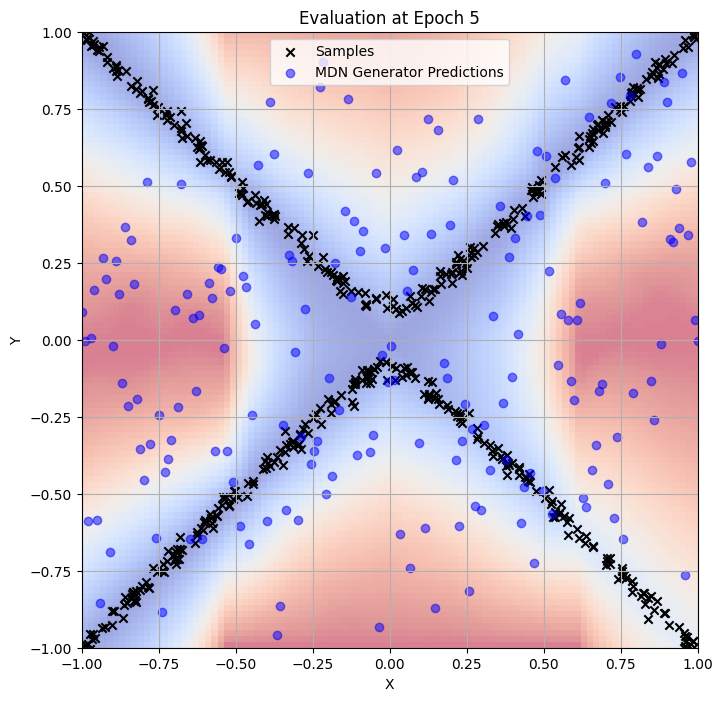

Epoch [6/100], Energy Loss: 2.2618, Generator Loss: 2.7107, Generator Energy Loss: 2.8341, Generator MDN Loss: -0.1234
Epoch [7/100], Energy Loss: 2.1225, Generator Loss: 3.0197, Generator Energy Loss: 3.0953, Generator MDN Loss: -0.0757
Epoch [8/100], Energy Loss: 2.0959, Generator Loss: 3.3295, Generator Energy Loss: 3.5710, Generator MDN Loss: -0.2414
Epoch [9/100], Energy Loss: 1.9719, Generator Loss: 2.9822, Generator Energy Loss: 3.3486, Generator MDN Loss: -0.3664
Epoch [10/100], Energy Loss: 1.9245, Generator Loss: 3.2721, Generator Energy Loss: 3.6777, Generator MDN Loss: -0.4056


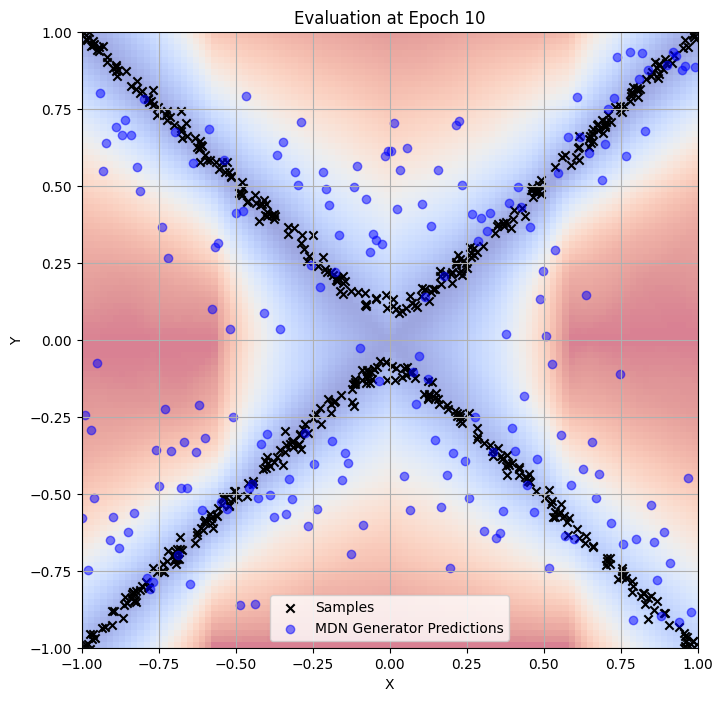

Epoch [11/100], Energy Loss: 1.8607, Generator Loss: 3.1467, Generator Energy Loss: 3.6501, Generator MDN Loss: -0.5035
Epoch [12/100], Energy Loss: 1.8336, Generator Loss: 2.4538, Generator Energy Loss: 3.2918, Generator MDN Loss: -0.8381
Epoch [13/100], Energy Loss: 1.8310, Generator Loss: 2.1944, Generator Energy Loss: 3.1320, Generator MDN Loss: -0.9376
Epoch [14/100], Energy Loss: 1.8122, Generator Loss: 1.5272, Generator Energy Loss: 2.7624, Generator MDN Loss: -1.2352
Epoch [15/100], Energy Loss: 1.8150, Generator Loss: 1.5381, Generator Energy Loss: 2.6915, Generator MDN Loss: -1.1534


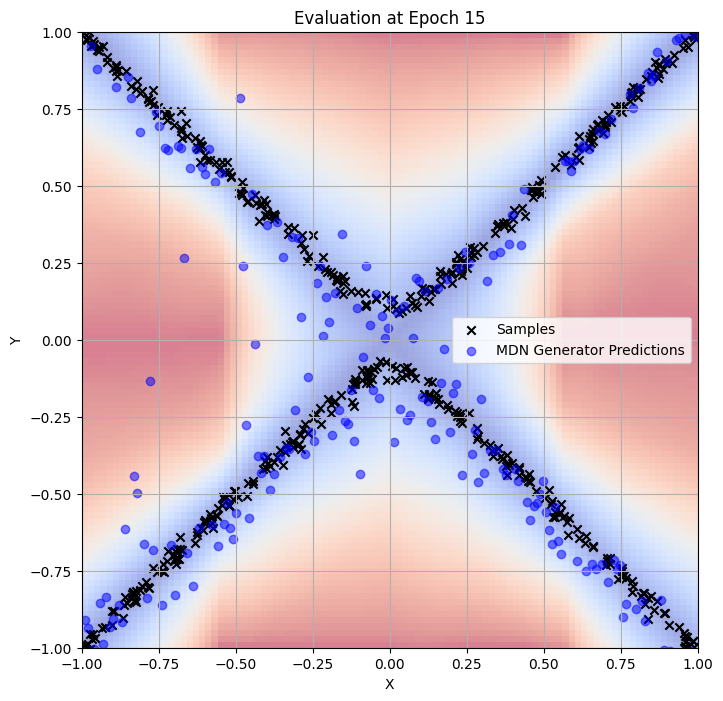

Epoch [16/100], Energy Loss: 1.7797, Generator Loss: 1.3524, Generator Energy Loss: 2.6715, Generator MDN Loss: -1.3191
Epoch [17/100], Energy Loss: 1.7610, Generator Loss: 1.0400, Generator Energy Loss: 2.5492, Generator MDN Loss: -1.5091
Epoch [18/100], Energy Loss: 1.7395, Generator Loss: 0.9029, Generator Energy Loss: 2.5135, Generator MDN Loss: -1.6106
Epoch [19/100], Energy Loss: 1.7325, Generator Loss: 0.6013, Generator Energy Loss: 2.2422, Generator MDN Loss: -1.6409
Epoch [20/100], Energy Loss: 1.7389, Generator Loss: 0.6439, Generator Energy Loss: 2.2930, Generator MDN Loss: -1.6491


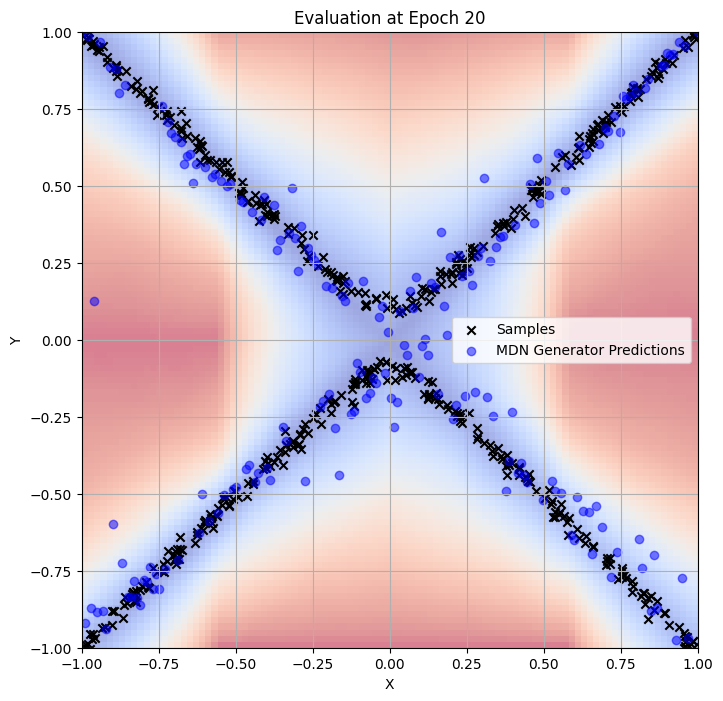

Epoch [21/100], Energy Loss: 1.6905, Generator Loss: 0.5172, Generator Energy Loss: 2.3051, Generator MDN Loss: -1.7880
Epoch [22/100], Energy Loss: 1.7085, Generator Loss: 0.1690, Generator Energy Loss: 2.1477, Generator MDN Loss: -1.9788
Epoch [23/100], Energy Loss: 1.6905, Generator Loss: -0.2978, Generator Energy Loss: 1.8172, Generator MDN Loss: -2.1150
Epoch [24/100], Energy Loss: 1.6666, Generator Loss: -0.3969, Generator Energy Loss: 1.7940, Generator MDN Loss: -2.1910
Epoch [25/100], Energy Loss: 1.6884, Generator Loss: -0.1444, Generator Energy Loss: 1.8141, Generator MDN Loss: -1.9585


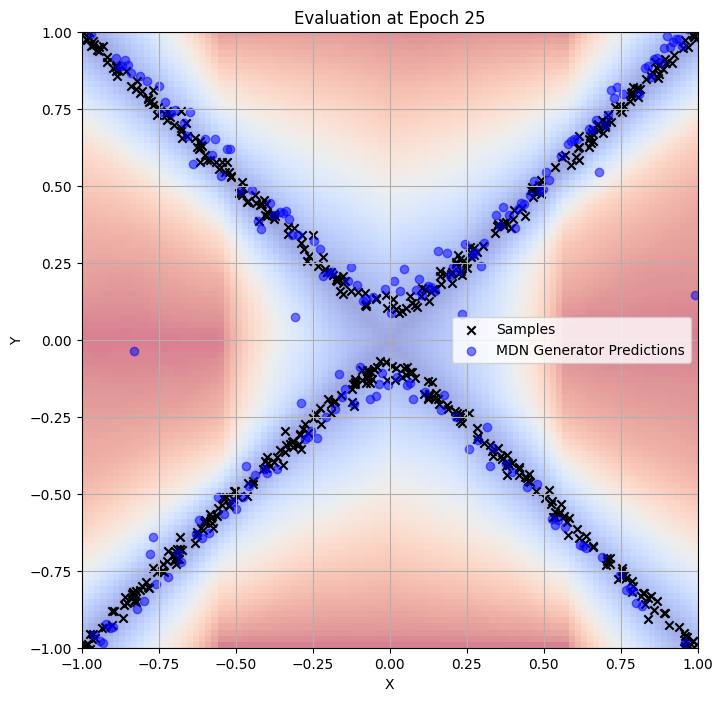

Epoch [26/100], Energy Loss: 1.6752, Generator Loss: 0.0834, Generator Energy Loss: 2.0856, Generator MDN Loss: -2.0022
Epoch [27/100], Energy Loss: 1.6540, Generator Loss: -0.0177, Generator Energy Loss: 2.0341, Generator MDN Loss: -2.0518
Epoch [28/100], Energy Loss: 1.6760, Generator Loss: -0.0620, Generator Energy Loss: 1.9853, Generator MDN Loss: -2.0473
Epoch [29/100], Energy Loss: 1.6962, Generator Loss: -0.0976, Generator Energy Loss: 2.0138, Generator MDN Loss: -2.1114
Epoch [30/100], Energy Loss: 1.6819, Generator Loss: -0.3436, Generator Energy Loss: 1.8620, Generator MDN Loss: -2.2056


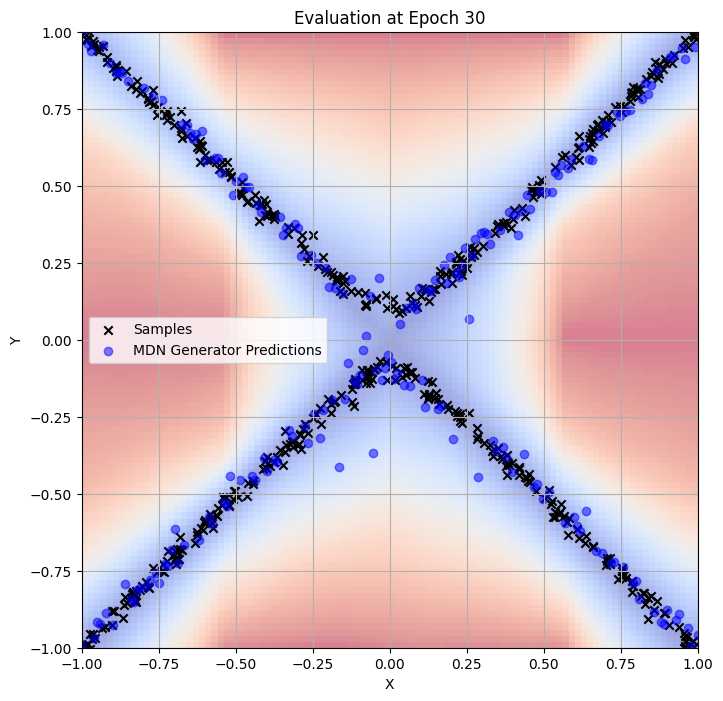

Epoch [31/100], Energy Loss: 1.7042, Generator Loss: -0.4323, Generator Energy Loss: 1.8528, Generator MDN Loss: -2.2851
Epoch [32/100], Energy Loss: 1.6419, Generator Loss: 0.2543, Generator Energy Loss: 2.2653, Generator MDN Loss: -2.0110
Epoch [33/100], Energy Loss: 1.6371, Generator Loss: 0.1388, Generator Energy Loss: 2.0775, Generator MDN Loss: -1.9387
Epoch [34/100], Energy Loss: 1.6495, Generator Loss: -0.2409, Generator Energy Loss: 1.9403, Generator MDN Loss: -2.1812
Epoch [35/100], Energy Loss: 1.6632, Generator Loss: -0.2975, Generator Energy Loss: 1.9375, Generator MDN Loss: -2.2351


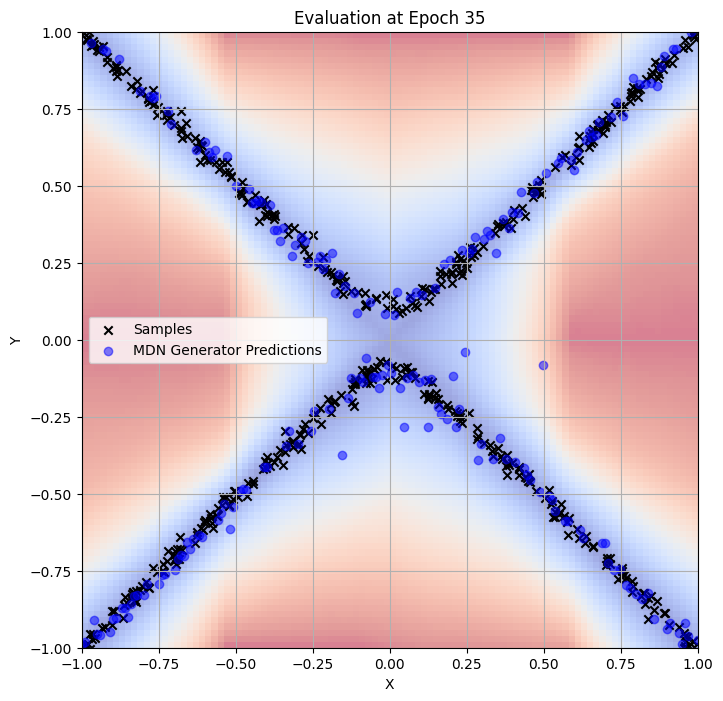

Epoch [36/100], Energy Loss: 1.6587, Generator Loss: -0.4151, Generator Energy Loss: 1.8591, Generator MDN Loss: -2.2742
Epoch [37/100], Energy Loss: 1.6529, Generator Loss: -0.4598, Generator Energy Loss: 1.8192, Generator MDN Loss: -2.2790
Epoch [38/100], Energy Loss: 1.6600, Generator Loss: -0.4461, Generator Energy Loss: 1.8418, Generator MDN Loss: -2.2879
Epoch [39/100], Energy Loss: 1.6192, Generator Loss: -0.2414, Generator Energy Loss: 1.8750, Generator MDN Loss: -2.1165
Epoch [40/100], Energy Loss: 1.6452, Generator Loss: -0.3014, Generator Energy Loss: 2.0199, Generator MDN Loss: -2.3213


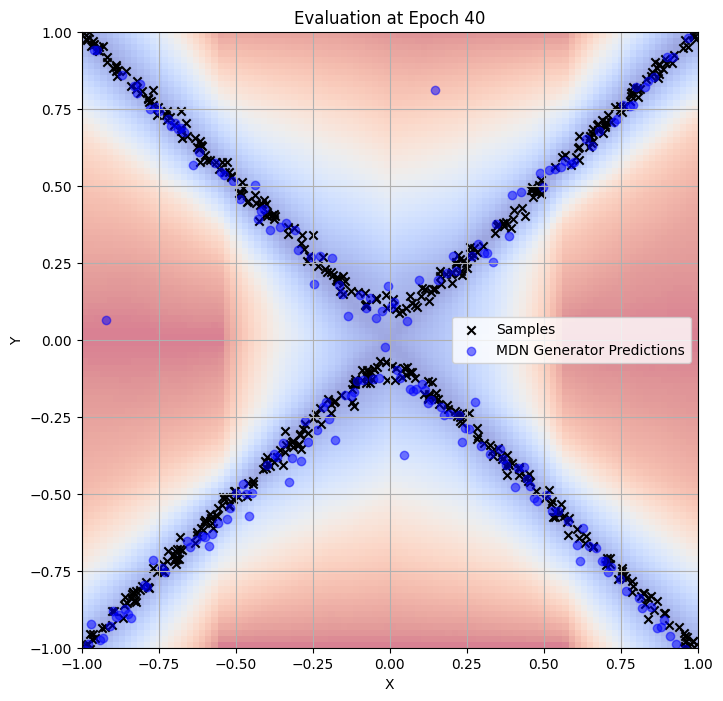

Epoch [41/100], Energy Loss: 1.6181, Generator Loss: -0.3426, Generator Energy Loss: 1.8793, Generator MDN Loss: -2.2220
Epoch [42/100], Energy Loss: 1.6210, Generator Loss: -0.3992, Generator Energy Loss: 1.9329, Generator MDN Loss: -2.3320
Epoch [43/100], Energy Loss: 1.6035, Generator Loss: -0.1705, Generator Energy Loss: 2.1505, Generator MDN Loss: -2.3210
Epoch [44/100], Energy Loss: 1.6268, Generator Loss: -0.2371, Generator Energy Loss: 2.0515, Generator MDN Loss: -2.2886
Epoch [45/100], Energy Loss: 1.6027, Generator Loss: -0.3246, Generator Energy Loss: 2.0543, Generator MDN Loss: -2.3789


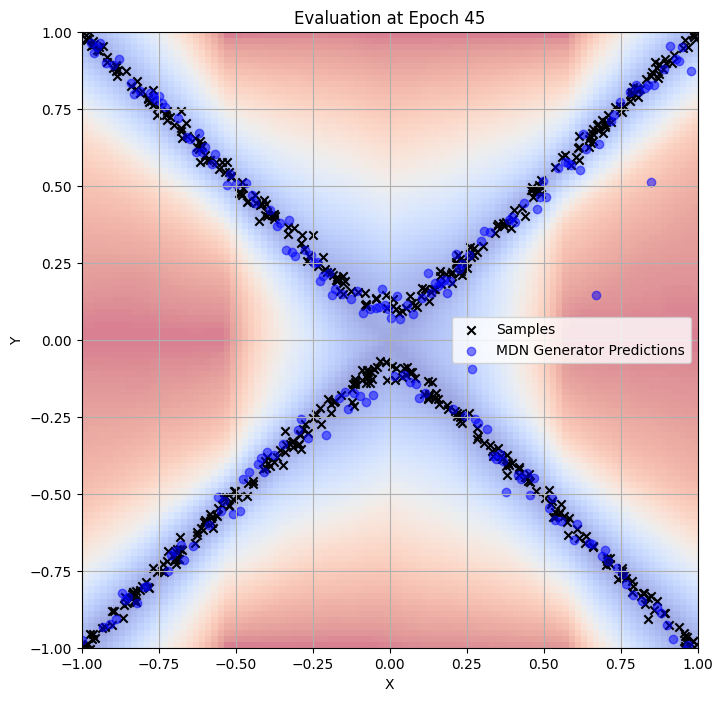

Epoch [46/100], Energy Loss: 1.6249, Generator Loss: -0.2213, Generator Energy Loss: 2.1426, Generator MDN Loss: -2.3639
Epoch [47/100], Energy Loss: 1.6405, Generator Loss: -0.2402, Generator Energy Loss: 2.1076, Generator MDN Loss: -2.3479
Epoch [48/100], Energy Loss: 1.6474, Generator Loss: -0.1686, Generator Energy Loss: 2.1988, Generator MDN Loss: -2.3674
Epoch [49/100], Energy Loss: 1.6078, Generator Loss: -0.5036, Generator Energy Loss: 1.9118, Generator MDN Loss: -2.4154
Epoch [50/100], Energy Loss: 1.6176, Generator Loss: -0.4397, Generator Energy Loss: 1.9596, Generator MDN Loss: -2.3993


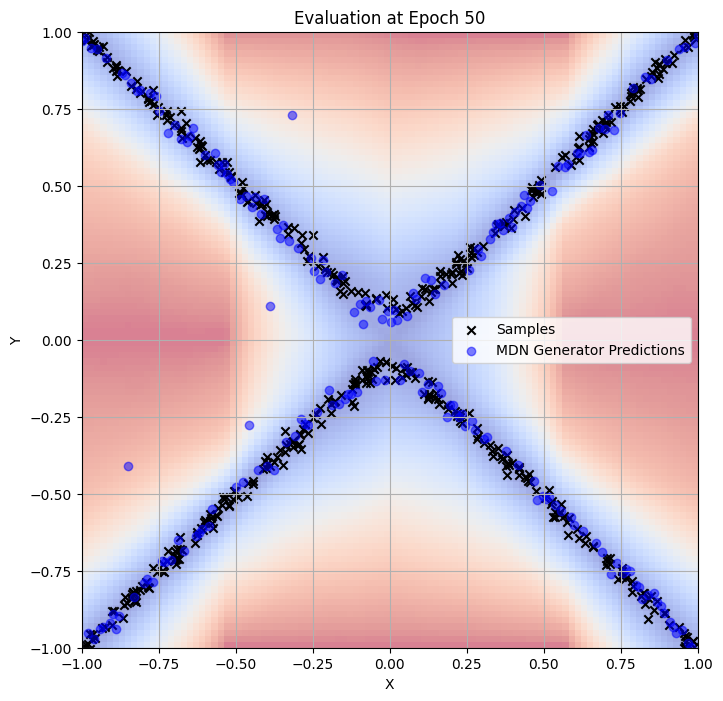

Epoch [51/100], Energy Loss: 1.6234, Generator Loss: -0.3862, Generator Energy Loss: 1.9988, Generator MDN Loss: -2.3849
Epoch [52/100], Energy Loss: 1.5982, Generator Loss: -0.3426, Generator Energy Loss: 2.0604, Generator MDN Loss: -2.4030
Epoch [53/100], Energy Loss: 1.6102, Generator Loss: -0.3040, Generator Energy Loss: 2.1399, Generator MDN Loss: -2.4439
Epoch [54/100], Energy Loss: 1.6179, Generator Loss: -0.3043, Generator Energy Loss: 2.1036, Generator MDN Loss: -2.4079
Epoch [55/100], Energy Loss: 1.6186, Generator Loss: -0.3961, Generator Energy Loss: 2.0348, Generator MDN Loss: -2.4309


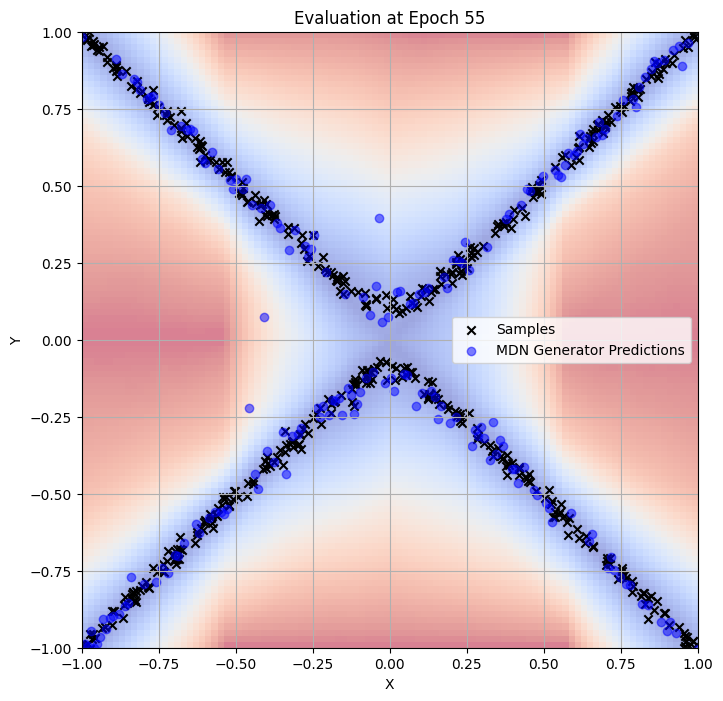

Epoch [56/100], Energy Loss: 1.6251, Generator Loss: -0.5523, Generator Energy Loss: 1.9281, Generator MDN Loss: -2.4804
Epoch [57/100], Energy Loss: 1.6313, Generator Loss: -0.3096, Generator Energy Loss: 2.0578, Generator MDN Loss: -2.3673
Epoch [58/100], Energy Loss: 1.6243, Generator Loss: -0.5068, Generator Energy Loss: 1.9418, Generator MDN Loss: -2.4486
Epoch [59/100], Energy Loss: 1.5912, Generator Loss: -0.0938, Generator Energy Loss: 2.2073, Generator MDN Loss: -2.3011
Epoch [60/100], Energy Loss: 1.6009, Generator Loss: -0.3003, Generator Energy Loss: 2.1113, Generator MDN Loss: -2.4117


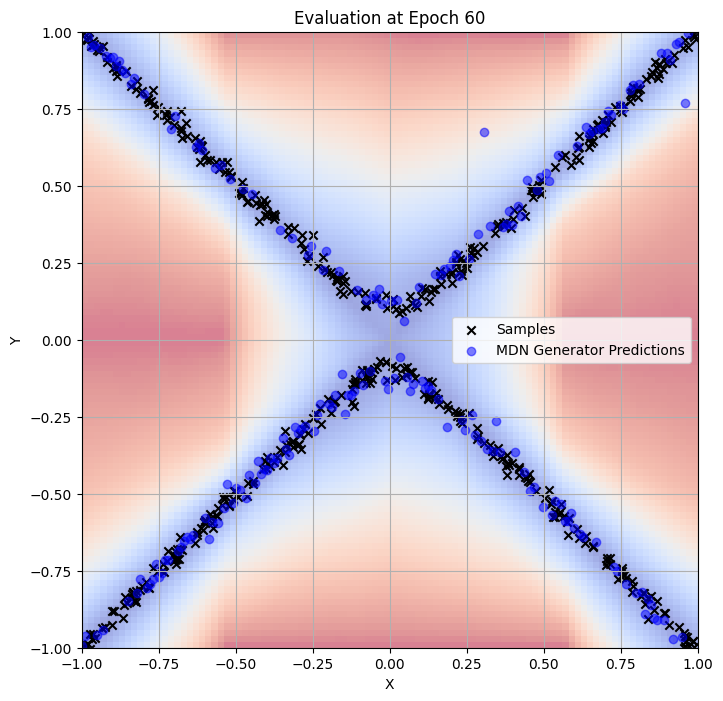

Epoch [61/100], Energy Loss: 1.5921, Generator Loss: -0.2699, Generator Energy Loss: 2.1245, Generator MDN Loss: -2.3944
Epoch [62/100], Energy Loss: 1.6054, Generator Loss: -0.5753, Generator Energy Loss: 1.9385, Generator MDN Loss: -2.5138
Epoch [63/100], Energy Loss: 1.6049, Generator Loss: -0.3753, Generator Energy Loss: 2.1505, Generator MDN Loss: -2.5258
Epoch [64/100], Energy Loss: 1.5977, Generator Loss: -0.3498, Generator Energy Loss: 2.1561, Generator MDN Loss: -2.5059
Epoch [65/100], Energy Loss: 1.5966, Generator Loss: -0.4659, Generator Energy Loss: 2.1006, Generator MDN Loss: -2.5664


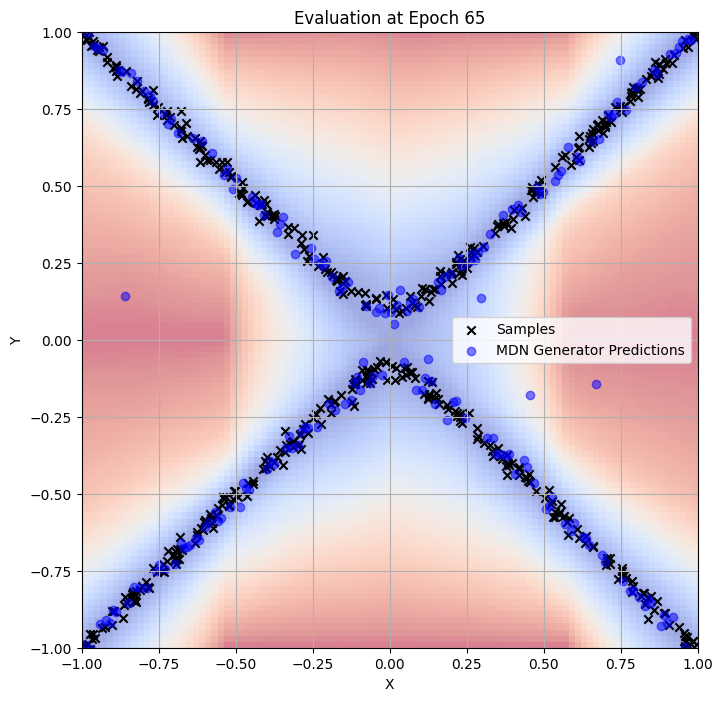

Epoch [66/100], Energy Loss: 1.5985, Generator Loss: -0.3369, Generator Energy Loss: 2.1585, Generator MDN Loss: -2.4955
Epoch [67/100], Energy Loss: 1.6075, Generator Loss: -0.3594, Generator Energy Loss: 2.0746, Generator MDN Loss: -2.4339
Epoch [68/100], Energy Loss: 1.5841, Generator Loss: -0.3299, Generator Energy Loss: 2.1615, Generator MDN Loss: -2.4915
Epoch [69/100], Energy Loss: 1.5981, Generator Loss: -0.4155, Generator Energy Loss: 2.0825, Generator MDN Loss: -2.4980
Epoch [70/100], Energy Loss: 1.5793, Generator Loss: -0.2008, Generator Energy Loss: 2.2097, Generator MDN Loss: -2.4105


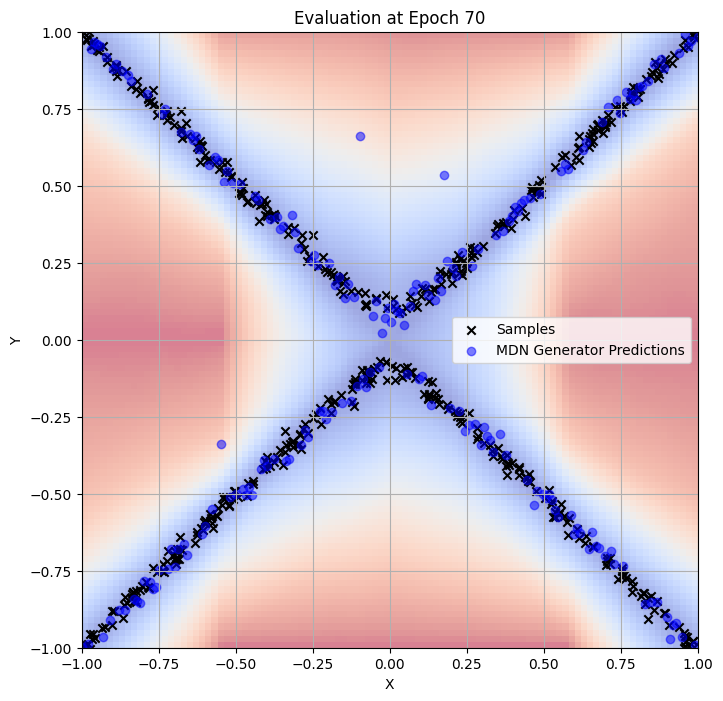

Epoch [71/100], Energy Loss: 1.5925, Generator Loss: -0.3388, Generator Energy Loss: 2.0697, Generator MDN Loss: -2.4086
Epoch [72/100], Energy Loss: 1.5985, Generator Loss: -0.3863, Generator Energy Loss: 2.0630, Generator MDN Loss: -2.4493
Epoch [73/100], Energy Loss: 1.5997, Generator Loss: -0.2059, Generator Energy Loss: 2.1081, Generator MDN Loss: -2.3140
Epoch [74/100], Energy Loss: 1.5805, Generator Loss: -0.3494, Generator Energy Loss: 2.0897, Generator MDN Loss: -2.4392
Epoch [75/100], Energy Loss: 1.5932, Generator Loss: -0.3075, Generator Energy Loss: 2.0858, Generator MDN Loss: -2.3933


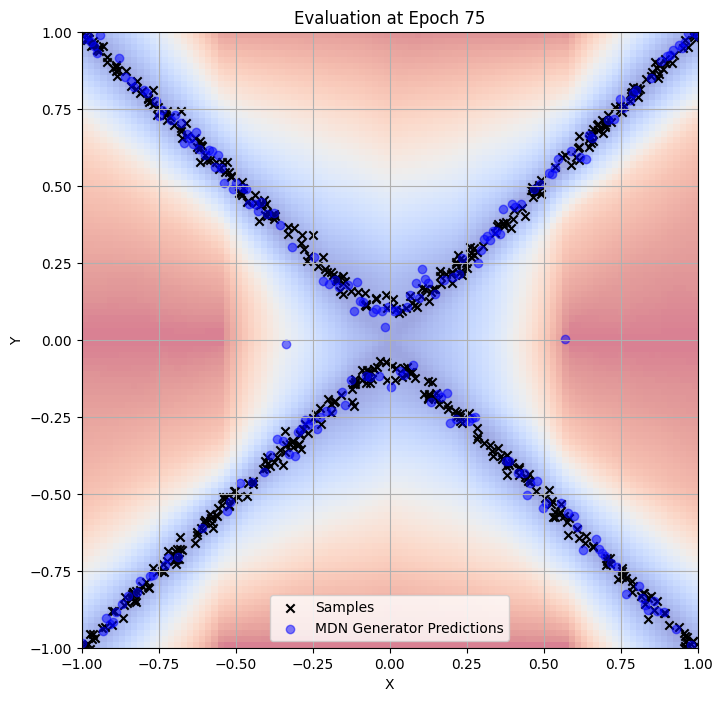

Epoch [76/100], Energy Loss: 1.5821, Generator Loss: -0.5047, Generator Energy Loss: 1.9983, Generator MDN Loss: -2.5031
Epoch [77/100], Energy Loss: 1.5727, Generator Loss: -0.3846, Generator Energy Loss: 2.0703, Generator MDN Loss: -2.4549
Epoch [78/100], Energy Loss: 1.5734, Generator Loss: -0.3451, Generator Energy Loss: 2.1150, Generator MDN Loss: -2.4601
Epoch [79/100], Energy Loss: 1.5845, Generator Loss: -0.4216, Generator Energy Loss: 1.9776, Generator MDN Loss: -2.3991
Epoch [80/100], Energy Loss: 1.5707, Generator Loss: -0.4266, Generator Energy Loss: 2.0032, Generator MDN Loss: -2.4298


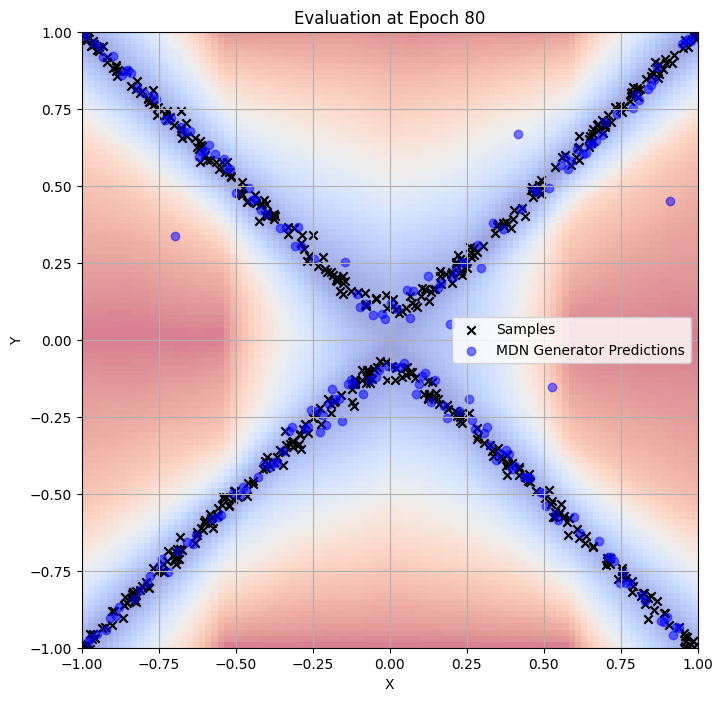

Epoch [81/100], Energy Loss: 1.5782, Generator Loss: -0.4579, Generator Energy Loss: 1.9877, Generator MDN Loss: -2.4456
Epoch [82/100], Energy Loss: 1.5837, Generator Loss: -0.2828, Generator Energy Loss: 2.1519, Generator MDN Loss: -2.4347
Epoch [83/100], Energy Loss: 1.5754, Generator Loss: -0.4503, Generator Energy Loss: 2.0500, Generator MDN Loss: -2.5003
Epoch [84/100], Energy Loss: 1.5772, Generator Loss: -0.4622, Generator Energy Loss: 2.0699, Generator MDN Loss: -2.5321
Epoch [85/100], Energy Loss: 1.5935, Generator Loss: -0.2695, Generator Energy Loss: 2.2417, Generator MDN Loss: -2.5112


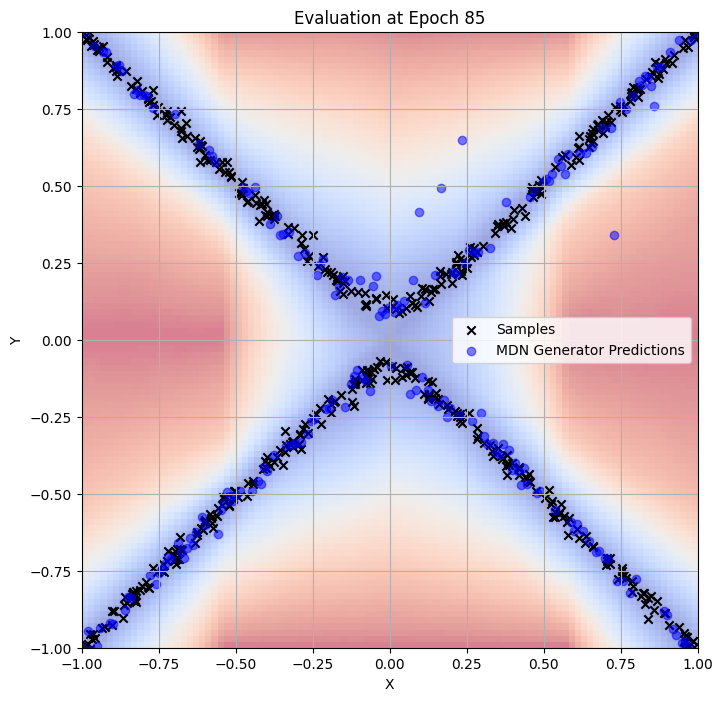

Epoch [86/100], Energy Loss: 1.5688, Generator Loss: -0.4993, Generator Energy Loss: 2.0847, Generator MDN Loss: -2.5840
Epoch [87/100], Energy Loss: 1.5820, Generator Loss: -0.4682, Generator Energy Loss: 2.0206, Generator MDN Loss: -2.4888
Epoch [88/100], Energy Loss: 1.5778, Generator Loss: -0.2696, Generator Energy Loss: 2.2014, Generator MDN Loss: -2.4710
Epoch [89/100], Energy Loss: 1.5816, Generator Loss: -0.3830, Generator Energy Loss: 2.0291, Generator MDN Loss: -2.4120
Epoch [90/100], Energy Loss: 1.5815, Generator Loss: -0.5703, Generator Energy Loss: 2.0052, Generator MDN Loss: -2.5755


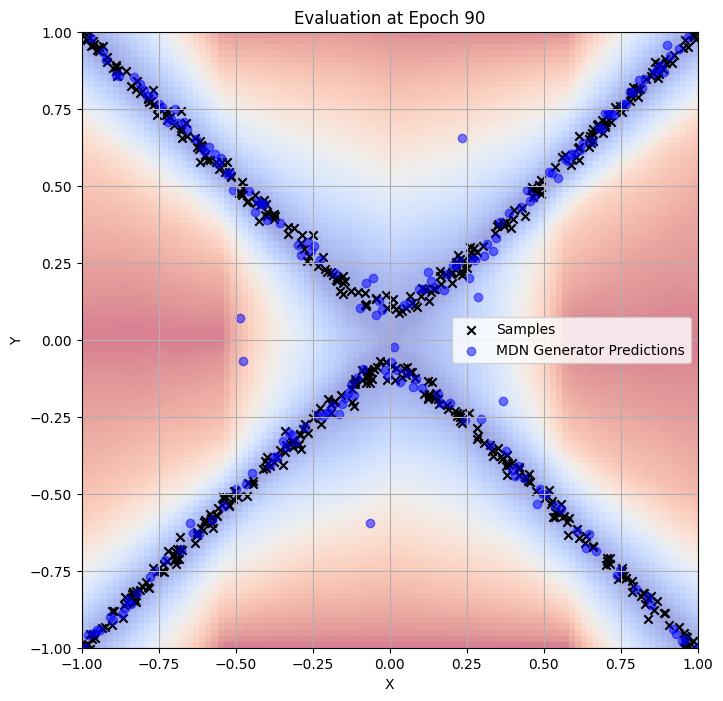

Epoch [91/100], Energy Loss: 1.5834, Generator Loss: -0.4644, Generator Energy Loss: 2.0188, Generator MDN Loss: -2.4832
Epoch [92/100], Energy Loss: 1.5895, Generator Loss: -0.5288, Generator Energy Loss: 1.9944, Generator MDN Loss: -2.5232
Epoch [93/100], Energy Loss: 1.5648, Generator Loss: -0.5402, Generator Energy Loss: 1.9930, Generator MDN Loss: -2.5332
Epoch [94/100], Energy Loss: 1.5692, Generator Loss: -0.1605, Generator Energy Loss: 2.3483, Generator MDN Loss: -2.5088
Epoch [95/100], Energy Loss: 1.5831, Generator Loss: -0.4287, Generator Energy Loss: 2.0625, Generator MDN Loss: -2.4912


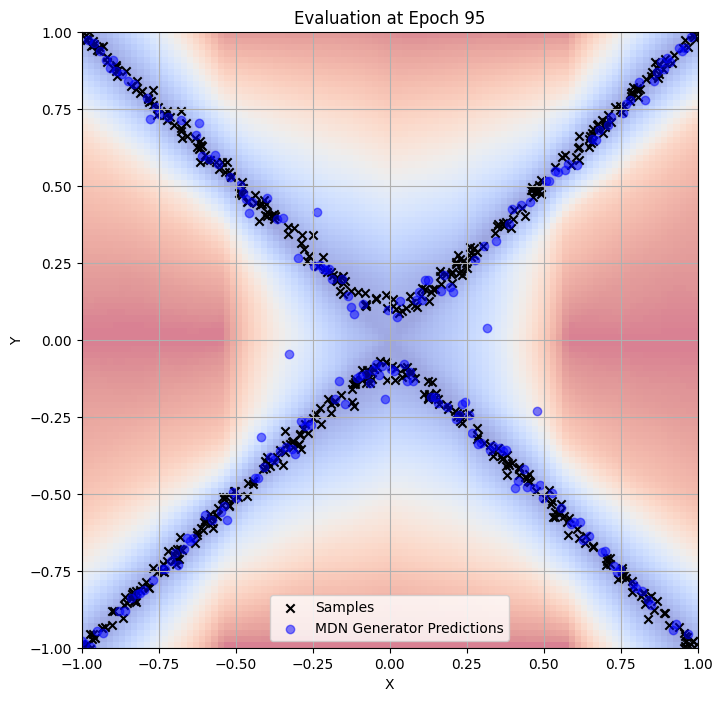

Epoch [96/100], Energy Loss: 1.5744, Generator Loss: -0.3504, Generator Energy Loss: 2.1535, Generator MDN Loss: -2.5039
Epoch [97/100], Energy Loss: 1.5849, Generator Loss: -0.2714, Generator Energy Loss: 2.0994, Generator MDN Loss: -2.3708
Epoch [98/100], Energy Loss: 1.5731, Generator Loss: -0.2579, Generator Energy Loss: 2.2659, Generator MDN Loss: -2.5238
Epoch [99/100], Energy Loss: 1.5860, Generator Loss: -0.4306, Generator Energy Loss: 2.1464, Generator MDN Loss: -2.5770
Epoch [100/100], Energy Loss: 1.5763, Generator Loss: -0.4325, Generator Energy Loss: 1.9803, Generator MDN Loss: -2.4128


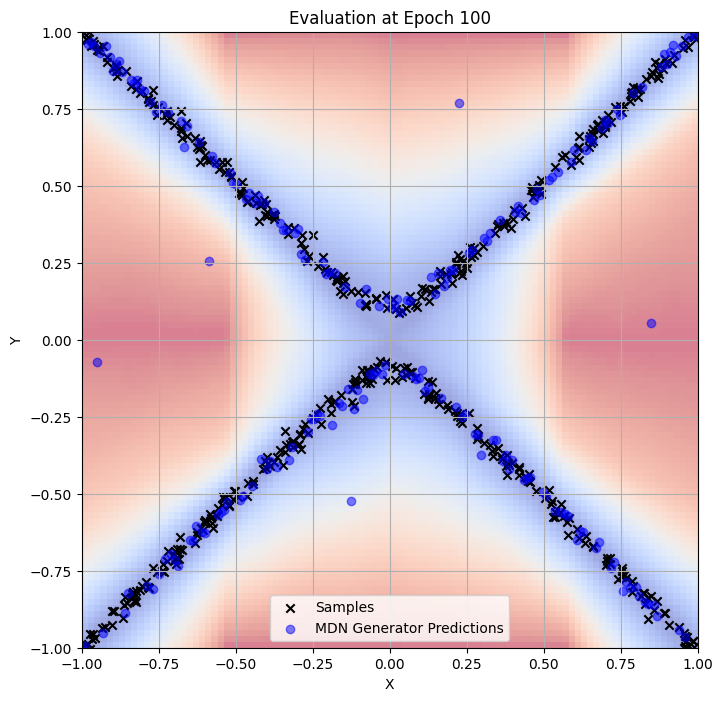

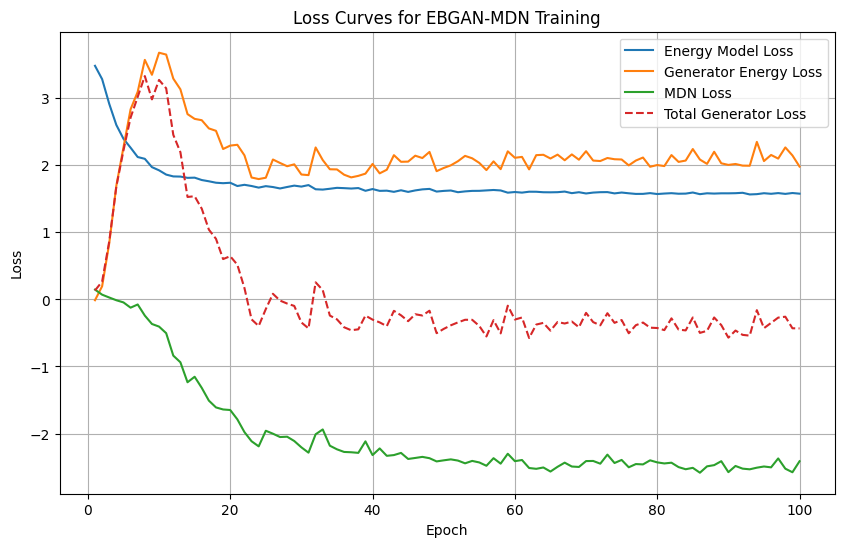

In [60]:
train_ebgan_mdn_with_visualization(dataloader, ebgan_energy_model, ebgan_mdn_generator, optimizer_ebgan_e, optimizer_ebgan_g, 
                    scheduler_e, scheduler_g, num_epochs, None,
                    y_min, y_max, neg_count, repeat_energy_updates, device, 
                    alpha, dynamic_scaling_true,
                    min_scale, epoch_num_eval)

# Other models

## 1. Explicit BC

## 2. MDN

## 3. 